In [1]:
import mne
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from stormdb.access import Query
from pickle import load
from scipy import stats
from mne.datasets import sample
from mne.stats import spatio_temporal_cluster_1samp_test
import os
from os import path as op
import pickle
from copy import deepcopy
import warnings
import src.group_stats as gs
import src.decoding_functions as df
import importlib
importlib.reload(gs)
importlib.reload(df)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# Set directories
project = 'MINDLAB2020_MEG-AuditoryPatternRecognition'
project_dir = '/projects/' + project
stats_dir = project_dir + '/scratch/working_memory/results/stats/'
figures_dir = project_dir + '/scratch/working_memory/results/figures/'
dem_file = project_dir + '/misc/WM_demographics.csv'

In [3]:
subs = np.arange(11,91) 
exclude = np.array([51,55,60,73,82])
suffix = ''
sdata, scodes, times, names = gs.load_connectivity(subs,suffix,exclude)

loading subject 11
loading subject 12
could not load subject 0012_VK2
[Errno 2] No such file or directory: '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/averages/data/0012_VK2/0012_VK2_conn.p'
loading subject 13
loading subject 14
loading subject 15
loading subject 16
loading subject 17
loading subject 18
loading subject 19
loading subject 20
loading subject 21
loading subject 22
loading subject 23
could not load subject 0023_ZPC
[Errno 2] No such file or directory: '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/averages/data/0023_ZPC/0023_ZPC_conn.p'
loading subject 24
loading subject 25
loading subject 26
loading subject 27
loading subject 28
loading subject 29
loading subject 30
could not load subject 0030_2MP
[Errno 2] No such file or directory: '/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/averages/data/0030_2MP/0030_2MP_conn.p'
loading subject 31
loading subject 32
could not load subject 0

In [4]:
sdata = {sk: np.squeeze(sdata[sk]) for sk in sdata}
smean, sstd, sci_lower, sci_upper, smedian, siqr_lower, siqr_upper = gs.grand_avg_scores(sdata)

In [5]:
smean['delta_whole'].shape

(100, 1001)

In [6]:
CI = {ss: {'lower': sci_lower[ss], 'upper': sci_upper[ss]} for ss in sci_lower}

In [7]:
FDR_stats = {s: gs.do_stats(sdata[s],'FDR',h0 = 0) for s in sdata}
masks     = {sm: FDR_stats[sm]['mask'] for sm in FDR_stats}


Performing FDR correction

100100

Performing FDR correction

100100


delta_whole
theta_whole


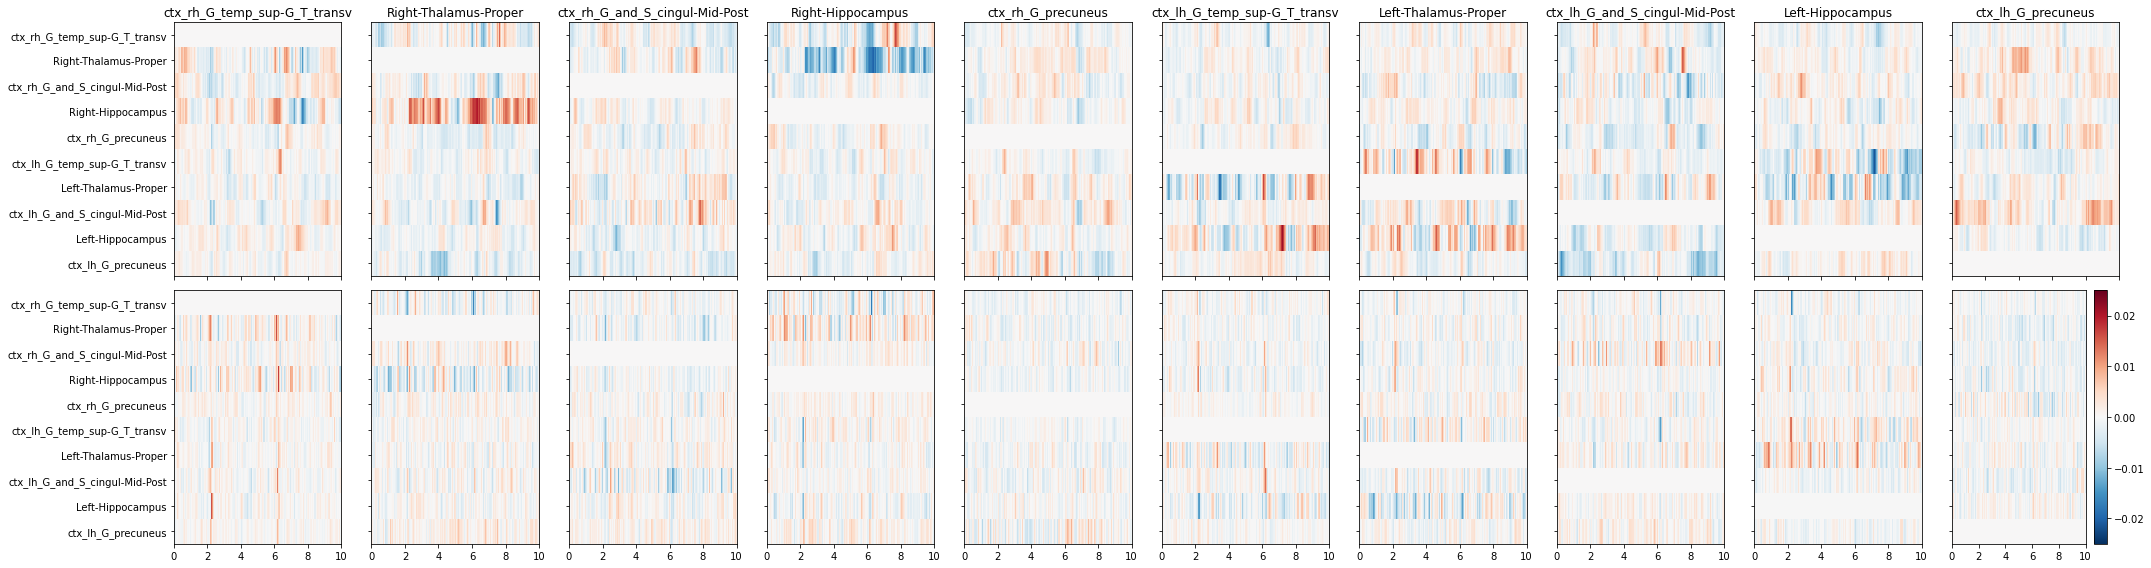

In [10]:
## Make and save a plot
fig, ax = plt.subplots(2,10,figsize = (30,8),sharex=True, sharey=True)
for bix,b in enumerate(sdata):
    print(b)
    bdata =  np.squeeze(smedian[b]).reshape(10,10,-1)
    for rix, r in enumerate(names):
        cdata = np.squeeze(bdata[rix,:,:].copy())
        cdata[(rix+1):,:] = bdata[(rix+1):,rix,:]*-1
        axx, axy = rix % 10, rix // 10 + 1*bix
        ix = np.arange(10) + rix*10        
        im = ax[axy, axx].imshow(cdata, aspect='auto',vmin=-.025,vmax=.025,
                  interpolation='nearest',cmap='RdBu_r',extent=[times[0],times[-1],len(names),0])#origin='lower'
#         if axy != 3:
#             ax[axy, axx].set_xticks([])
        if axy == 0:
            ax[axy, axx].set_title(r)
        
        if axx == 0:
            ax[axy, axx].set_yticks(np.arange(len(names)) + .5)
            ax[axy, axx].set_yticklabels(names)
fig.colorbar(im)
plt.tight_layout()
# plt.savefig(fig_path)

In [134]:
tix = {'listened': [a and b for a,b in zip(times>=2,times<4)],
       'imagined': [a and b for a,b in zip(times>=4,times<6)]}
reduced = {sk: np.append(sdata[sk][:,:,tix['listened']].mean(2,keepdims = True),
                         sdata[sk][:,:,tix['imagined']].mean(2,keepdims = True),2) for sk in sdata}

In [56]:
#reduced = {dk: reduced[dk].reshape(reduced[dk].shape[0],10,10,-1) for dk in reduced}

In [135]:
reduced_diff = {dk: np.diff(reduced[dk]) for dk in reduced}

In [136]:
FDR_single = {s: gs.do_stats(reduced_diff[s],'FDR',h0 = 0) for s in reduced}


Performing FDR correction

100

Performing FDR correction

100


In [137]:
for dk in FDR_single:
    pix = np.squeeze(np.isnan(FDR_single[dk]['pvals']) == False)
    FDR_single[dk]['qvals'][pix] = mne.stats.fdr_correction(FDR_single[dk]['pvals'][pix])[1]
    FDR_single[dk]['mask'][pix] = mne.stats.fdr_correction(FDR_single[dk]['pvals'][pix])[0]

In [138]:
FDR_single

{'delta_whole': {'mask': array([[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
     

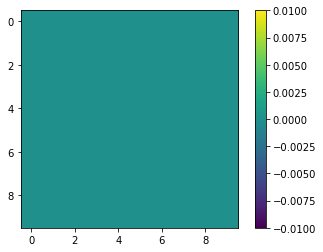

In [140]:
im = plt.imshow((FDR_single['delta_whole']['data_mean']*FDR_single['delta_whole']['mask']).reshape(10,10),vmin = -.01, vmax = .01)
plt.colorbar(im)

/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scripts/working_memory/src/decoding_functions.py:215: UserWarning: No contour levels were found within the data range.
  cax.contour(masks[s].copy().astype('float'), levels=[-.1,1], colors='k',


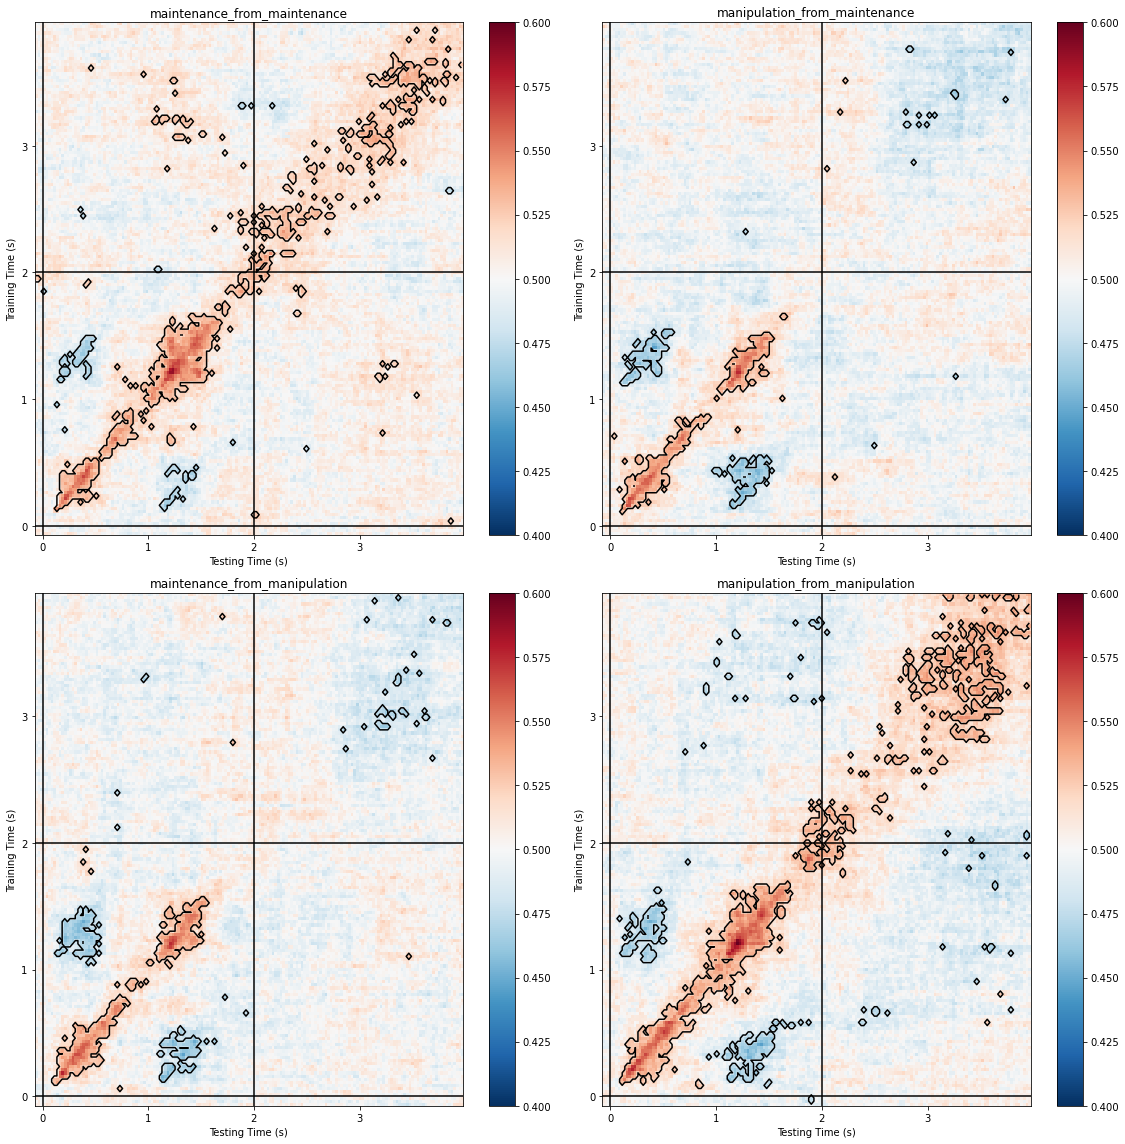

In [8]:
df.plot_time_gen_accuracy(smean, times,  masks = masks,
                          nrows=2, ncols=2, vlines=[2], hlines=[2],
                          savefig=None, vmin=.4,vmax=.6)

In [9]:
cluster_stats = {}
for s in sdata:
    print('doing stats for {}'.format(s))
    cluster_stats[s] = gs.do_stats(sdata[s],method='montecarlo',h0=1/2,n_permutations=2000)

doing stats for maintenance_from_maintenance
Clustering.
stat_fun(H1): min=-5.025104 max=9.098720
Running initial clustering
Found 770 clusters
Permuting 1999 times...


  0%|          |  : 0/1999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
doing stats for manipulation_from_maintenance
Clustering.
stat_fun(H1): min=-7.737352 max=8.296447
Running initial clustering
Found 750 clusters
Permuting 1999 times...


  0%|          |  : 0/1999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
doing stats for maintenance_from_manipulation
Clustering.
stat_fun(H1): min=-6.945163 max=9.602940
Running initial clustering
Found 748 clusters
Permuting 1999 times...


  0%|          |  : 0/1999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
doing stats for manipulation_from_manipulation
Clustering.
stat_fun(H1): min=-6.704437 max=9.798874
Running initial clustering
Found 769 clusters
Permuting 1999 times...


  0%|          |  : 0/1999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [10]:
cluster_masks = {sm: cluster_stats[sm]['mask'] for sm in cluster_stats}

/projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scripts/working_memory/src/decoding_functions.py:215: UserWarning: No contour levels were found within the data range.
  cax.contour(masks[s].copy().astype('float'), levels=[-.1,1], colors='k',


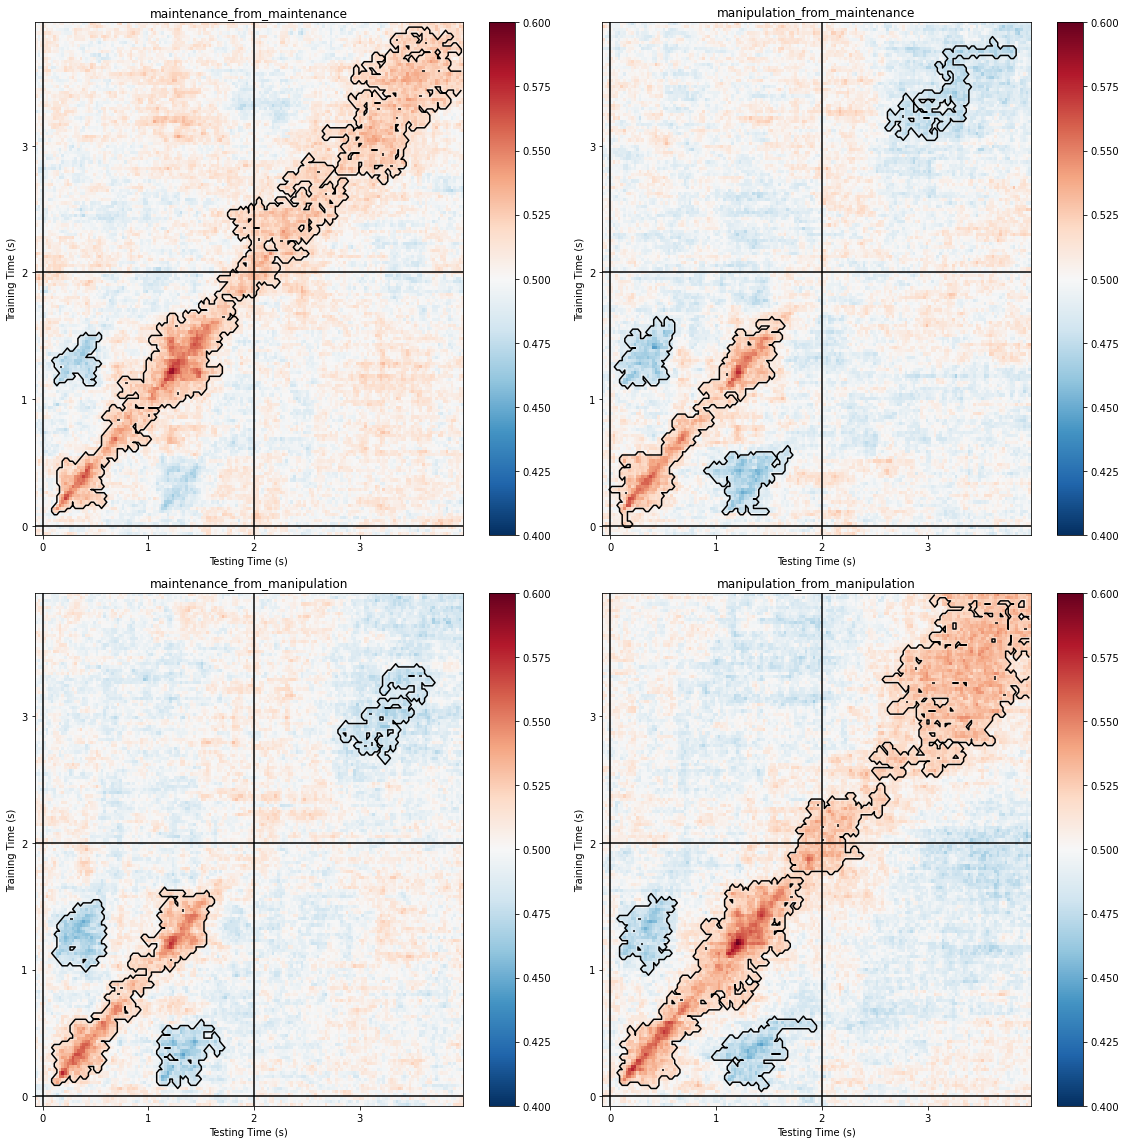

In [11]:
df.plot_time_gen_accuracy(smean, times,  masks = cluster_masks,
                          nrows=2, ncols=2, vlines=[2], hlines=[2],
                          savefig=None, vmin=.4,vmax=.6)

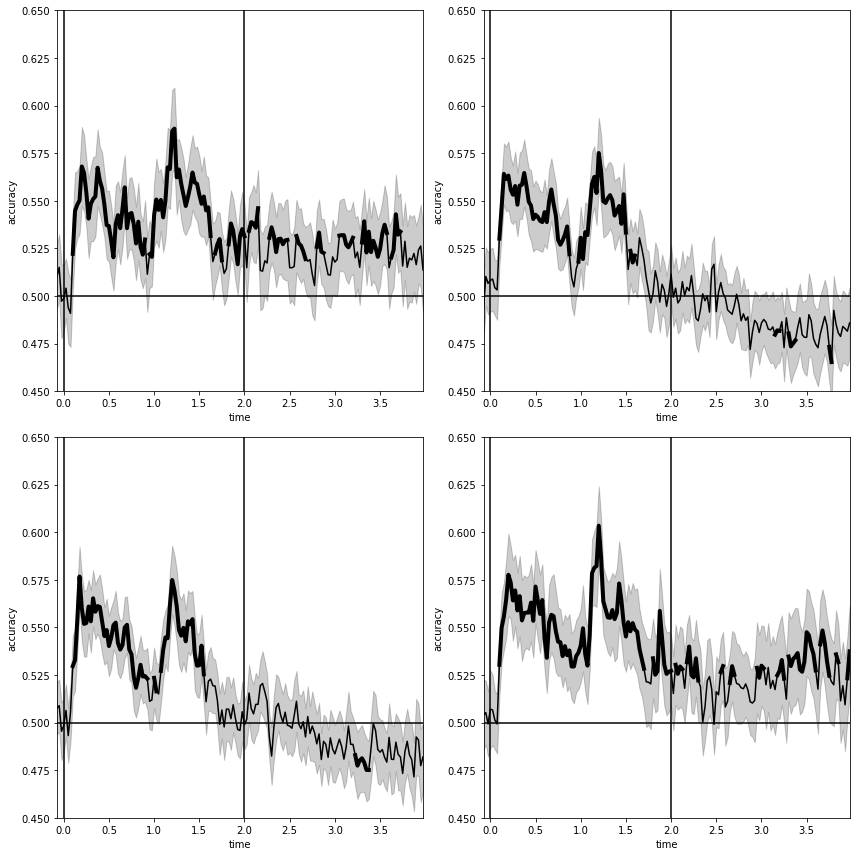

In [12]:
df.plot_diagonal_accuracy(smean, times,  masks = cluster_masks, CI=CI,
                          nrows=2, ncols=2, vlines=[2], hlines=[],
                          savefig=None, ylims=(.45,.65), chance=1/2)

In [13]:
# load demographics
dem = pd.read_csv(dem_file)
dem = dem[np.isin(dem['Subject'],scodes)]
print(dem)

    Subject  Age Sex  vividness difficulty previous  musicianship  yomt
0        11   24   F        3.0          3       No           1.0  16.0
1        12   31   F        1.0          0      Yes           0.0   NaN
2        13   21   F        NaN          1      NaN           0.0   NaN
3        14   28   M        NaN          3      NaN           0.0   NaN
4        15   27   M        NaN          3      NaN           0.0   NaN
..      ...  ...  ..        ...        ...      ...           ...   ...
74       86   27   F        1.0          1      Yes           0.0   NaN
75       87   32   M        NaN        NaN      NaN           NaN   NaN
76       88   18   F        1.0         -1       No           0.0   NaN
77       89   20   F        2.0          2       No           1.0   7.0
78       90   36   F       -2.0          3       No           0.0   NaN

[73 rows x 8 columns]


In [ ]:
cluster_reg_stats = {}
#preds = np.array([dem['vividness']]).T
preds = np.array([dem['vividness']]).T
for s in sdata:
    print('doing stats for {}'.format(s))
    cdata = np.array(sdata[s].copy()) - 1/2
    cluster_reg_stats[s] = gs.do_regression(sdata[s], preds = preds, n_permutations=500)

doing stats for maintenance_from_maintenance
Clustering.
stat_fun(H1): min=-4.616699 max=5.938756
Running initial clustering
Found 1143 clusters
Permuting 499 times...


  0%|          |  : 0/499 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
doing stats for manipulation_from_maintenance
Clustering.
stat_fun(H1): min=-4.549475 max=5.505823
Running initial clustering
Found 1022 clusters
Permuting 499 times...


  0%|          |  : 0/499 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
doing stats for maintenance_from_manipulation
Clustering.
stat_fun(H1): min=-4.847531 max=4.884116
Running initial clustering
Found 1015 clusters
Permuting 499 times...


  0%|          |  : 0/499 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
doing stats for manipulation_from_manipulation
Clustering.
stat_fun(H1): min=-4.895130 max=4.658631
Running initial clustering
Found 949 clusters
Permuting 499 times...


  0%|          |  : 0/499 [00:00<?,       ?it/s]

In [ ]:
ctvals = {s: cluster_reg_stats[s]['tvals'] for s in cluster_reg_stats}
cmasks = {s: cluster_reg_stats[s]['mask'] for s in cluster_reg_stats}
df.plot_time_gen_accuracy(ctvals, times,  masks = cmasks,
                          nrows=2, ncols=2, vlines=[2], hlines=[2],
                          savefig=None, vmin=None,vmax=None)

In [ ]:
# # Compute linear regression
# betas, rval, reg_pvals, ci, aic = {},{},{},{},{}
# preds = np.array([dem['vividness'],dem['musicianship']]).T
# preds = sm.add_constant(preds)
# print(preds.shape)
# for s in sdata:
#     cdata = np.array(sdata[s].copy()) - 1/2
#     xshape = cdata.shape[1]
#     yshape = cdata.shape[2]
#     betas[s] = np.zeros((preds.shape[1],xshape,yshape))
#     rval[s] = np.zeros((xshape,yshape))
#     aic[s] = np.zeros((xshape,yshape))
#     reg_pvals[s] = np.zeros((preds.shape[1],xshape,yshape))
#     #ci[s] = np.zeros(betas[s].shape)
#     for y in range(yshape):
#         for x in range(xshape):
#             print('regressing condition {} training sample: {}/{}, testing sample: {}/{}'.format(s,x+1,xshape,y+1,yshape))
#             res = sm.OLS(cdata[:,x,y],preds,missing='drop').fit()
#             betas[s][:,x,y] = res.params
#             reg_pvals[s][:,x,y] = res.pvalues
#             rval[s][x,y] = res.rsquared
#             aic[s][x,y] = res.aic

In [ ]:
# # compute correlations with vividness
# pvals = {}
# cors = {}
# for s in sdata:
#     sdata[s] = np.array(sdata[s])
#     xshape = sdata[s].shape[1]
#     yshape = sdata[s].shape[2]
#     cors[s] = np.zeros((xshape,yshape))
#     pvals[s] = np.zeros((xshape,yshape))
#     for y in range(yshape):
#         for x in range(xshape):
#             print('correlating condition {} training sample: {}/{}, testing sample: {}/{}'.format(s,x,xshape,y,yshape))
#             nanix = np.isnan(np.array(dem['vividness'])) == False
#             #print(nanix)
# #             cur_cor = np.array(pd.DataFrame({'a': sdata[s][:,x,y], 'b': np.array(dem['vividness'])}).corr())[0,1]
# #             print(cur_cor)
#             cors[s][x,y], pvals[s][x,y] = stats.pearsonr(sdata[s][nanix,x,y], np.array(dem['vividness'][nanix]))                   

In [ ]:
# ncols = 2
# fig, axes = plt.subplots(ncols=ncols,nrows=2, figsize = (20,13)) #,gridspec_kw=dict(width_ratios=[1,1,1,1]) )
# for sidx,s in enumerate(cors):
#     f,se = s.split('_from_')
#     ext = [-.1,smean[s].shape[1] * .025,  
#            -.1,smean[s].shape[0] * .025]
#     rix, cix = sidx//ncols,sidx%ncols
#     mask = pvals[s] <= .025
#     im = axes[rix, cix].matshow(cors[s]*mask, vmin = -1, vmax = 1,#vmin=0.18, vmax=0.48,
#                                       cmap='RdBu_r', origin='lower', extent=ext)
#     axes[rix, cix].axhline(0., color='k')
#     axes[rix, cix].axvline(0., color='k')
#     axes[rix, cix].xaxis.set_ticks_position('bottom')
#     axes[rix, cix].set_xlabel('Testing Time (s)')
#     axes[rix, cix].set_ylabel('Training Time (s)')
#     axes[rix, cix].set_anchor('W')
#     axes[rix, cix].set_title('pred. {}'.format(s),{'horizontalalignment': 'center'})
# cbar_ax = fig.add_axes([0.925,0.15,0.01,0.7])
# fig.colorbar(im,cax=cbar_ax)
# fig.suptitle('Vividness correlation', fontsize =  20)
# plt.tight_layout()

In [ ]:
# #plot musicians and nonmusicians
# varnames = {'intercept': 0, 'vividness': 1, 'musicianship': 2}
# ncols = 2
# for ex in varnames:
#     fig, axes = plt.subplots(ncols=ncols,nrows=2, figsize = (20,13)) #,gridspec_kw=dict(width_ratios=[1,1,1,1]) )
#     for sidx,s in enumerate(betas):
#         f,se = s.split('_from_')
#         ext = [-.1,smean[s].shape[1] * .025,  
#                -.1,smean[s].shape[0] * .025]
#         rix, cix = sidx//ncols,sidx%ncols
#         mask = reg_pvals[s][varnames[ex]] < .025
#         im = axes[rix, cix].matshow(betas[s][varnames[ex]]*mask,# vmin = .4, vmax = .6,#vmin=0.18, vmax=0.48,
#                                           cmap='RdBu_r', origin='lower', extent=ext)
#         axes[rix, cix].axhline(0., color='k')
#         axes[rix, cix].axvline(0., color='k')
#         axes[rix, cix].xaxis.set_ticks_position('bottom')
#         axes[rix, cix].set_xlabel('Testing Time (s)')
#         axes[rix, cix].set_ylabel('Training Time (s)')
#         axes[rix, cix].set_anchor('W')
#         axes[rix, cix].set_title('pred. {}'.format(s),{'horizontalalignment': 'center'})
#     cbar_ax = fig.add_axes([0.925,0.15,0.01,0.7])
#     fig.colorbar(im,cax=cbar_ax)
#     fig.suptitle('Decoding accuracy (ROC - AUC) {}'.format(ex), fontsize =  20)
#     plt.tight_layout()
# #plt.savefig(avg_path + '/figures/{}_accuracies_imagined.pdf'.format(sub),orientation='landscape')


In [ ]:
# eix0 = np.array(dem['musicianship']) == 0
# eix1 = np.array(dem['musicianship']) == 1
# print(eix0)
# print(eix1)
# fig, axes = plt.subplots(ncols=ncols,nrows=4, figsize = (20,13)) #,gridspec_kw=dict(width_ratios=[1,1,1,1]) )
# for sidx,s in enumerate(sdata):
#     f,se = s.split('_from_')

#     ext = [-.25,smean[s].shape[1] * .025 - 0.25,  
#            -.25,smean[s].shape[0] * .025 - 0.25]
#     rix, cix = sidx//ncols,sidx%ncols
#     im = axes[rix, cix].matshow(sdata[s][eix1].mean(axis=0) - sdata[s][eix0].mean(axis=0), #vmin = .4, vmax = .6,#vmin=0.18, vmax=0.48,
#                                       cmap='RdBu_r', origin='lower', extent=ext)
#     axes[rix, cix].axhline(0., color='k')
#     axes[rix, cix].axvline(0., color='k')
#     axes[rix, cix].xaxis.set_ticks_position('bottom')
#     axes[rix, cix].set_xlabel('Testing Time (s)')
#     axes[rix, cix].set_ylabel('Training Time (s)')
#     axes[rix, cix].set_anchor('W')
#     axes[rix, cix].set_title('pred. {}'.format(s),{'horizontalalignment': 'center'})
# cbar_ax = fig.add_axes([0.925,0.15,0.01,0.7])
# fig.colorbar(im,cax=cbar_ax)
# fig.suptitle('Decoding accuracy (ROC - AUC) musicians - non-musicians', fontsize =  20)
# plt.tight_layout()